In [2]:
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

In [3]:
np.random.seed(12049)

In [4]:
def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity


def compute_confusion_matrix(
    predictions, valid_generator, class_names, model_name
):
    cm = confusion_matrix(
        y_true=valid_generator.labels,
        y_pred=np.argmax(predictions, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))


def make_gradcam_heatmap(grad_model, img_array, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        superimposed_img
    )

    return superimposed_img

In [30]:
base_dir = "C:/Users/haris/Downloads/KNEE_OA/Dataset"
test_path = os.path.join(base_dir, 'test')

class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

tests_data = get_classes(test_path, class_names, 'test')

---- test ----
Grade 0 - Healthy: 639 images, 38.59%
Grade 1 - Doubtful: 296 images, 17.87%
Grade 2 - Minimal: 447 images, 26.99%
Grade 3 - Moderate: 223 images, 13.47%
Grade 4 - Severe: 51 images, 3.08%


In [31]:
model_name = "InceptionResNetV2"
batch_size = 256
target_size = (299, 299)  # InceptionResNetV2's default input size
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

In [32]:
noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input
)
test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1656 images belonging to 5 classes.


In [33]:
y_test = test_generator.labels

In [40]:
model_name = "Xception"
batch_size = 256
target_size = (224, 224)

In [41]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input
)

In [42]:
test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1656 images belonging to 5 classes.


In [43]:
y_test = test_generator.labels

In [44]:
xception = tf.keras.models.load_model('models/model_Xception_ft.hdf5')

In [45]:
predictions_xception = xception.predict(test_generator)
score_xception = xception.evaluate(test_generator, verbose=1)
print('Test loss:', score_xception[0])
print('Test acc:', score_xception[1])

7/7 [==============================] - 78s 7s/step

7/7 [==============================] - 49s 6s/step - loss: 0.9135 - accuracy: 0.6262
Test loss: 0.9135178923606873
Test acc: 0.626207709312439


In [46]:
get_metrics(
    test_generator.labels,
    y_pred=np.argmax(predictions_xception, axis=1),
    model_name=model_name,
)

Accuracy Score - Xception: 0.63
Balanced Accuracy Score - Xception: 0.61


              precision    recall  f1-score   support

           0       0.65      0.93      0.76       639
           1       0.29      0.28      0.29       296
           2       0.79      0.36      0.49       447
           3       0.81      0.70      0.75       223
           4       0.87      0.78      0.82        51

    accuracy                           0.63      1656
   macro avg       0.68      0.61      0.62      1656
weighted avg       0.65      0.63      0.61      1656



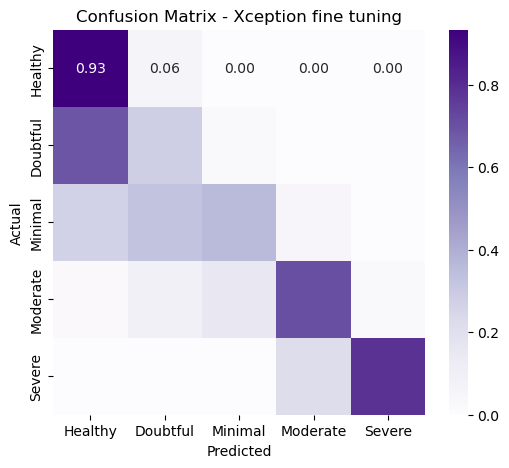

In [47]:
compute_confusion_matrix(
    predictions_xception,
    test_generator,
    class_names,
    f"{model_name} fine tuning",
)

In [48]:
xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20871725 (79.62 MB)
Trainable params: 20817197 (79.41 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [50]:
# Last layer
conv_output = xception.get_layer("global_average_pooling2d").input

grad_model = tf.keras.models.Model(
    [xception.inputs], [conv_output, xception.output]
)

# model
xception.layers[-1].activation = None

Test data - Healthy


C:\Users\haris\AppData\Local\Temp\ipykernel_1392\1560636948.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


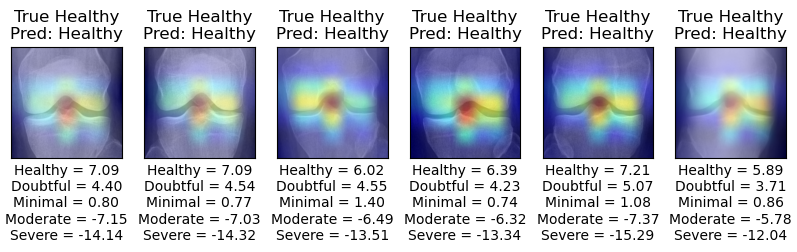

Test data - Doubtful


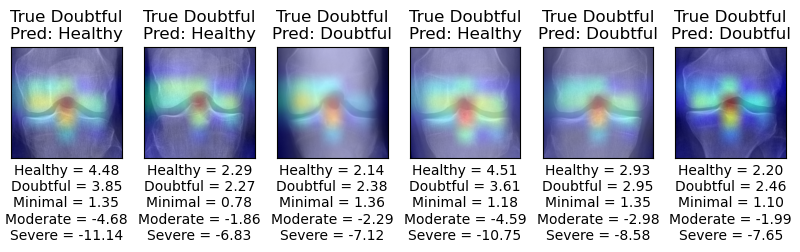

Test data - Minimal


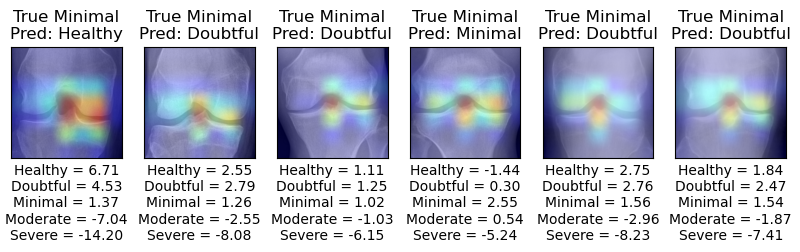

Test data - Moderate


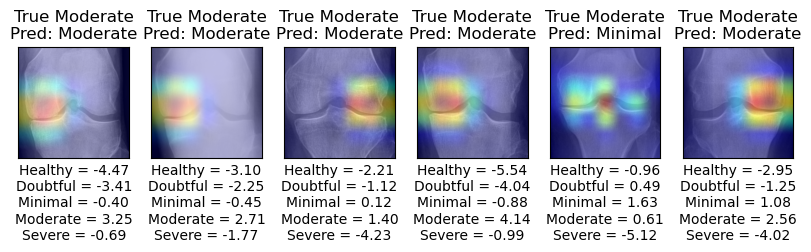

Test data - Severe


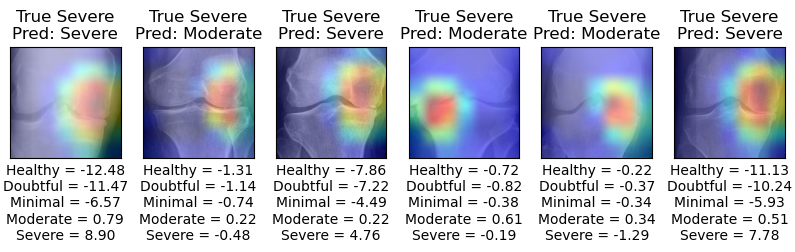

In [51]:
for k, v in tests_data.items():
    print(f"Test data - {class_names[k]}")
    plt.figure(figsize=(10, 28))
    for i in range(6):
        img_path = os.path.join(test_path, str(k), v[i])
        # prepare image
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=target_size
        )
        img = tf.keras.preprocessing.image.img_to_array(img)

        img_aux = img.copy()
        img_array = np.expand_dims(img_aux, axis=0)
        img_array = np.float32(img_array)
        img_array = tf.keras.applications.xception.preprocess_input(img_array)

        y_pred = xception.predict(img_array, verbose=0)[0]

        heatmap = make_gradcam_heatmap(grad_model, img_array)
        image = save_and_display_gradcam(img, heatmap)

        plt.subplot(1, 6, 1 + i, xticks=[], yticks=[])
        plt.imshow(image)
        plt.title(
            f"True {class_names[k]}\nPred: {class_names[np.argmax(y_pred)]}"
        )
        plt.xlabel(
            "\n".join([f"{c} = {p:.2f}" for c, p in zip(class_names, y_pred)])
        )
    plt.show() 